<a href="https://colab.research.google.com/github/robimalco/colab/blob/main/House_prices_advanced_regression_techniques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Download files



- **SalePrice** - the property's sale price in dollars. This is the target variable that you're trying to predict.
- **MSSubClass**: The building class
- **MSZoning**: The general zoning classification
- **LotFrontage**: Linear feet of street connected to property
- **LotArea**: Lot size in square feet
- **Street**: Type of road access
- **Alley**: Type of alley access
- **LotShape**: General shape of property
- **LandContour**: Flatness of the property
- **Utilities**: Type of utilities available
- **LotConfig**: Lot configuration
- **LandSlope**: Slope of property
- **Neighborhood**: Physical locations within Ames city limits
- **Condition1**: Proximity to main road or railroad
- **Condition2**: Proximity to main road or railroad (if a second is present)
- **BldgType**: Type of dwelling
- **HouseStyle**: Style of dwelling
- **OverallQual**: Overall material and finish quality
- **OverallCond**: Overall condition rating
- **YearBuilt**: Original construction date
- **YearRemodAdd**: Remodel date
- **RoofStyle**: Type of roof
- **RoofMatl**: Roof material
- **Exterior1st**: Exterior covering on house
- **Exterior2nd**: Exterior covering on house (if more than one material)
- **MasVnrType**: Masonry veneer type
- **MasVnrArea**: Masonry veneer area in square feet
- **ExterQual**: Exterior material quality
- **ExterCond**: Present condition of the material on the exterior
- **Foundation**: Type of foundation
- **BsmtQual**: Height of the basement
- **BsmtCond**: General condition of the basement
- **BsmtExposure**: Walkout or garden level basement walls
- **BsmtFinType1**: Quality of basement finished area
- **BsmtFinSF1**: Type 1 finished square feet
- **BsmtFinType2**: Quality of second finished area (if present)
- **BsmtFinSF2**: Type 2 finished square feet
- **BsmtUnfSF**: Unfinished square feet of basement area
- **TotalBsmtSF**: Total square feet of basement area
- **Heating**: Type of heating
- **HeatingQC**: Heating quality and condition
- **CentralAir**: Central air conditioning
- **Electrical**: Electrical system
- **1stFlrSF**: First Floor square feet
- **2ndFlrSF**: Second floor square feet
- **LowQualFinSF**: Low quality finished square feet (all floors)
- **GrLivArea**: Above grade (ground) living area square feet
- **BsmtFullBath**: Basement full bathrooms
- **BsmtHalfBath**: Basement half bathrooms
- **FullBath**: Full bathrooms above grade
- **HalfBath**: Half baths above grade
- **Bedroom**: Number of bedrooms above basement level
- **Kitchen**: Number of kitchens
- **KitchenQual**: Kitchen quality
- **TotRmsAbvGrd**: Total rooms above grade (does not include bathrooms)
- **Functional**: Home functionality rating
- **Fireplaces**: Number of fireplaces
- **FireplaceQu**: Fireplace quality
- **GarageType**: Garage location
- **GarageYrBlt**: Year garage was built
- **GarageFinish**: Interior finish of the garage
- **GarageCars**: Size of garage in car capacity
- **GarageArea**: Size of garage in square feet
- **GarageQual**: Garage quality
- **GarageCond**: Garage condition
- **PavedDrive**: Paved driveway
- **WoodDeckSF**: Wood deck area in square feet
- **OpenPorchSF**: Open porch area in square feet
- **EnclosedPorch**: Enclosed porch area in square feet
- **3SsnPorch**: Three season porch area in square feet
- **ScreenPorch**: Screen porch area in square feet
- **PoolArea**: Pool area in square feet
- **PoolQC**: Pool quality
- **Fence**: Fence quality
- **MiscFeature**: Miscellaneous feature not covered in other categories
- **MiscVal**: $Value of miscellaneous feature
- **MoSold**: Month Sold
- **YrSold**: Year Sold
- **SaleType**: Type of sale
- **SaleCondition**: Condition of sale

# Configure and import

In [ ]:
from google.colab import files
files.upload()

In [ ]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c house-prices-advanced-regression-techniques

In [28]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Data Import

In [182]:
original_train_df = pd.read_csv('train.csv')
original_train_df['Source'] = 'train.csv'

original_test_df = pd.read_csv('test.csv')
original_test_df['Source'] = 'test.csv'

total_df = pd.concat([original_train_df, original_test_df], axis=0)

## Data Exploration

In [183]:
numerical_columns = []
categorical_columns = []

for column in total_df.columns:
  if total_df.dtypes[column] == np.int64 or total_df.dtypes[column] == np.float64:
    numerical_columns.append(column)
  else:
    categorical_columns.append(column)

categorical_columns.remove('Source')
numerical_columns.remove('SalePrice')

In [ ]:
# Plot GarageYrBlt Histogram

temp_df = total_df['GarageYrBlt'] - total_df['YearBuilt']
temp_df.columns = ['DeltaYears']

temp_df.plot.hist(bins=5, alpha=0.5)

In [ ]:
# Plot Correlation Matrix

temp_df = total_df[numerical_columns]
f = plt.figure(figsize=(19, 15))
plt.matshow(temp_df.corr(), fignum=f.number)
plt.xticks(range(temp_df.shape[1]), temp_df.columns, fontsize=14, rotation=45)
plt.yticks(range(temp_df.shape[1]), temp_df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

In [ ]:
# Plot Correlation Only with column SalePrice

total_df[numerical_columns].corrwith(original_train_df['SalePrice']).sort_values()

In [168]:
# GarageYrBlt
# MiscVal
# Id
# YrSold 
# BsmtHalfBath
# numerical_columns.remove('GarageYrBlt')
# numerical_columns.remove('MiscVal')
# numerical_columns.remove('Id')
# numerical_columns.remove('YrSold')
# numerical_columns.remove('BsmtHalfBath')

In [184]:
cp_total_df = total_df
# cp_total_df = cp_total_df.drop(['Id'], axis=1)
# cp_total_df = cp_total_df.drop(['GarageYrBlt', 'MiscVal', 'Id', 'YrSold', 'BsmtHalfBath'], axis=1)

In [185]:
pd.options.mode.chained_assignment = None

for column in categorical_columns:
    cp_total_df[column] = cp_total_df[column].fillna('N/A')

for column in numerical_columns:
    cp_total_df[column] = cp_total_df[column].fillna(0)

for column in categorical_columns:
  cp_total_df[column] = LabelEncoder().fit_transform(cp_total_df[column])

for column in categorical_columns:
  cp_total_df[column] = cp_total_df[column].astype('category')

In [186]:
train_df = cp_total_df[cp_total_df['Source'] == 'train.csv']
train_output_df = pd.DataFrame(train_df['SalePrice'], columns=['SalePrice'])
train_df.drop('SalePrice', axis=1, inplace=True)

test_df = cp_total_df[cp_total_df['Source'] == 'test.csv']
test_df.drop('SalePrice', axis=1, inplace=True)

In [187]:
'Id' in cp_total_df.columns

True

In [188]:
def create_tensor(input_df):
  stack = []
  for column in categorical_columns:
    temp_stack = input_df[column].cat.codes.values
    stack.append(temp_stack)
  for column in numerical_columns:
    temp_stack = input_df[column].astype(np.float64)
    stack.append(temp_stack)
  return torch.tensor(np.stack(stack, 1), dtype=torch.float)

tensor_train = create_tensor(train_df).float()
tensor_output = torch.tensor(train_output_df['SalePrice']).flatten().float()

tensor_test = create_tensor(test_df).float()

In [189]:
total_records_train = len(tensor_train)
test_records_train = int(total_records_train * 0.2)

tensor_train_data = tensor_train[:total_records_train-test_records_train]
tensor_train_output = tensor_output[:total_records_train-test_records_train]

tensor_validation_data = tensor_train[total_records_train-test_records_train:total_records_train]
tensor_validation_output = tensor_output[total_records_train-test_records_train:total_records_train]

In [190]:
in_nodes = tensor_train.shape[1]

class Model(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear1 = nn.Linear(tensor_train.shape[1], 1000)
    self.linear2 = nn.Linear(1000, 500)
    self.linear3 = nn.Linear(500, 200)
    self.linear4 = nn.Linear(200, 1)
  def forward(self, x):
    y = self.linear1(x)
    y = torch.nn.functional.dropout(y, p=0.2)
    y = self.linear2(y)
    y = torch.nn.functional.dropout(y, p=0.2)
    y = self.linear3(y)
    y = torch.nn.functional.dropout(y, p=0.2)
    y = self.linear4(y)
    return y

In [191]:
model = Model()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [192]:
def train_model(epochs):
  aggregated_losses = []
  for i in range(epochs):
    y_pred = model(tensor_train_data)
    loss = loss_function(y_pred.squeeze(), tensor_train_output)
    optimizer.zero_grad() # sets the gradients of all optimized to zero.
    loss.backward() # compute gradient of loss with respect to all the parameters
    optimizer.step() # iterate and update all parameters based on the current gradient
    if i % 100 == 0:
      print("epoch: " + str(i) + "\tloss: " + str(loss.item()))
    if i % 50 == 0:
      aggregated_losses.append(loss)
  return aggregated_losses

In [193]:
def plot_losses(aggregated_losses):
  plt.plot(range(0, len(aggregated_losses)), aggregated_losses)
  plt.ylabel('Loss')
  plt.xlabel('epoch');

epoch: 0	loss: 38924238848.0
epoch: 100	loss: 2153316608.0
epoch: 200	loss: 1691347968.0
epoch: 300	loss: 1590008320.0
epoch: 400	loss: 1540495616.0
epoch: 500	loss: 1488625664.0
epoch: 600	loss: 1634452352.0
epoch: 700	loss: 1610561792.0
epoch: 800	loss: 1540420352.0
epoch: 900	loss: 1496353152.0


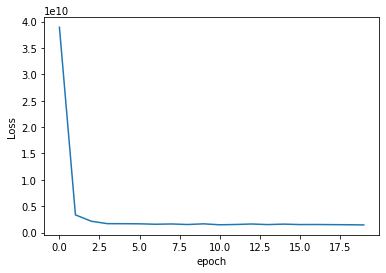

In [194]:
aggregated_losses = train_model(1000)
plot_losses(aggregated_losses)
# 900 --> 1098404864.0

In [ ]:
aggregated_losses = train_model(2000)
plot_losses(aggregated_losses)
# 1900 --> 842353984.0

In [181]:
# Overfitting if: training loss << validation loss
# Underfitting if: training loss >> validation loss
# Just right if training loss ~ validation loss

with torch.no_grad():
    y_val = model(tensor_validation_data)
    loss = loss_function(y_val.squeeze(), tensor_validation_output)
print("Loss: " + str(loss.item()))
# Loss -- >Loss: 2240462848.0

Loss: 3134692864.0


In [ ]:
# To remove overfitting
# cross-validation: use your initial training data to generate multiple mini train-test splits.
# Remove features: removing irrelevant input features or aggregate them 
# Early stopping: stopping the training process before the learner degradates.
regularization,
# Ensembling: machine learning methods for combining predictions from multiple separate models. 

In [ ]:
# Make predictions
with torch.no_grad():
    y_pred = model(tensor_test)
print("Loss: " + str(loss))

In [ ]:
submission_df = pd.DataFrame(y_pred, columns=['SalePrice']).astype("float")

submission_df = pd.concat([original_test_df, submission_df], axis=1)

submission_df = submission_df[['Id', 'SalePrice']]

from google.colab import files
submission_df.to_csv('submission.csv', index=False)
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>